In [1]:
# Load libraries
import pandas as pd
import numpy as np
# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
# Test / Train
from sklearn.model_selection import train_test_split
# Model selection libraries
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
# Scale
from sklearn.preprocessing import StandardScaler
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Load Files

In [2]:
# Read csv files
policies = pd.read_csv('data/motor_data14-2018.csv')

In [3]:
# policies.head()

## Data Preparation

### Convert Date Types

In [4]:
# Convert String Dates to Dates
policies.INSR_BEGIN = pd.to_datetime(policies.INSR_BEGIN)
policies.INSR_END = pd.to_datetime(policies.INSR_END)

In [5]:
# Filter to recent policies
policies = policies[(policies.INSR_BEGIN.dt.year==2018) | (policies.INSR_END.dt.year==2018)]

In [6]:
# policies.PROD_YEAR.describe()
# policies.SEATS_NUM.describe()
# policies.CARRYING_CAPACITY.describe()
# policies.CCM_TON.describe()

In [7]:
# Convert float to int
# Replace null with max value 2018
policies.PROD_YEAR.fillna(2018, inplace = True)
policies.PROD_YEAR = policies.PROD_YEAR.astype(int)
# Replace null seats with 1
policies.SEATS_NUM.fillna(1, inplace = True)
policies.SEATS_NUM = policies.SEATS_NUM.astype(int)
# Replace null carrying capacity at 0
policies.CARRYING_CAPACITY.fillna(0, inplace = True)
policies.CARRYING_CAPACITY = policies.CARRYING_CAPACITY.astype(int)
# Replace null with 0
policies.CCM_TON.fillna(0, inplace = True)
policies.CCM_TON = policies.CCM_TON.astype(int)

In [8]:
# If no claim replace with 0
policies.CLAIM_PAID.fillna(0, inplace = True)

In [9]:
# policies.EFFECTIVE_YR.unique()
policies.EFFECTIVE_YR = pd.to_numeric(policies.EFFECTIVE_YR, errors='coerce').fillna(18).astype(int)
# Convert effective year to year format
policies.EFFECTIVE_YR = np.where((policies.EFFECTIVE_YR > 18), policies.EFFECTIVE_YR + 1900, policies.EFFECTIVE_YR + 2000)

In [10]:
policies = policies.loc[policies['INSURED_VALUE'] == 0]

In [11]:
policies['PREMIUM'].fillna(policies['PREMIUM'].mean(), inplace=True)

### Filter

In [12]:
policies['MAKE'] = policies['MAKE'].replace(['MERCEEDES','MERCEEDICE','MERCHEDES','MERCEDICE','MERCEDIS','MERCEDES/SANY','MERCEDES AXOR','MERCEDES / 2521-48',
                                            'MERCEDES ATEGO-KELES','MERCEDES BENZ'], 'MERCEDES')

In [13]:
policies['MAKE'] = policies['MAKE'].replace(['NISSAN UD','NISSAN*','NISSAN SUNNY','NISAN','NISSAN X-TRIAL'], 'NISSAN')

In [14]:
policies['MAKE'] = policies['MAKE'].replace(['BELARUS TRACTOR','BELL TRACTOR','TRACTOR TRAILER','TRACTOR','CATERPILLAR TRACTOR','ENGLAND TRACTOR',
                                            'TRACTOR BELARUS', 'TRACTOR 4WD', 'TRACTOR4WD', 'ARTICULATED TRACTOR', 'BEL TRACTOR','VERSATILE TRACTOR',
                                            'YTO TRACTOR', 'URSUS TRACTOR URSUS TRACTOR', 'KAT TRACTOR','VALTRA TRACTOR','XERION TRACTOR','XERION TARCTOR',
                                            'TRAILER','HIGH BED TRAILER','SUGERCANE TRAILER','330-30 TRAILER','BEBEN SEMI TRAILER','CHINA SPECIAL SEMI TRAILER',
                                            '3-AXEL DRAWBAR CARGO TRAILER','3-AXLE DRAWBAR CARGO TRAILER','KAT TRAILER','LOW BED SEMITRAILER\n','SAL DA29 YARI TRAILER',
                                            'URSUS TRACTOR','TALER','TRAKKER'], 'TRACTOR/TRAILER')

In [15]:
policies['MAKE'] = policies['MAKE'].replace(['TOYOTA*','TOYOTA LAND CRUISER','TOYOTA PICK-UP','TOYOTA L/CRUISER',' TOYOTA RAV4','TOYOTA HILUX',
                                            'TOYOTA L/C PRADO','TOYOTA P/UP', 'TOYOTA RAV4','TOYOTA AUTOMOBILE','TOYOTA  AUTOMOBILE','TOYOTA YARIS',
                                            'TOYOTA COROLLA','TOYOTA REVO HILUX','TOYOTA VITZ','TOYTA','TOYOTA HIACE','TOYOTA RAVA4','TOYATA',
                                            ' TOYOTA VITZ','TOYOTA 4 RUNNER','TOYOTAA','TOYOTA  YARIS','TOYOTA PLATZ','TOYOTA  COROLA',' TOYOTA MINIBUS',
                                            'TOYOTA MERCHEDIS','T0Y0TA','T0Y0TA'], 'TOYOTA')

In [16]:
policies['MAKE'] = policies['MAKE'].replace(['MOTOR CYCLE (TWOCYCLE)','MOTOR CYCLE','M/CYCLE','M/CYCIE','HARLEY DAVIDSON','MOTOR CYLE'], 'MOTORCYCLE')

In [17]:
policies['MAKE'] = policies['MAKE'].replace(['FORD CARGO','FORD*','FORD RANGER'], 'FORD')

In [18]:
policies['MAKE'] = policies['MAKE'].replace(['ZTLTRUCK','AIRCARGO MOBILE TRUCK','BAYBEN TRUCK HIGHBED','EURO TRUCKER','VAN TRUCK','KAMA MINI TRUCK','KAMA NINI TRUCK',
                                            'KAMA LIGHT TRUCK','RIO JAMES TRUCK PALLET','POWER PLUS TRUCK','LOBADE TRUCK','SINO TRUCK','POWRPLUS TRUCK'], 'TRUCK')

In [19]:
# Filter for car make that is popular
policies = policies[policies.groupby("MAKE")['MAKE'].transform('size') >= 100]

In [20]:
# Only accept average vehicles with 6 or less seats
policies = policies[policies.SEATS_NUM<=6]

In [21]:
# Accept trucks and semitrailers but nothing larger
policies =policies[policies.CARRYING_CAPACITY <= 10]

In [22]:
# Accept trucks and semitrailers but nothing larger
policies =policies[policies.CCM_TON <= 5000]

In [23]:
# Remove outlier premiums
policies = policies[policies.PREMIUM <= 5000]

In [24]:
policies['USAGE'] = policies['USAGE'].replace(['Taxi', 'Car Hires', 'Fare Paying Passengers'], 'Taxi+')

In [25]:
policies['USAGE'] = policies['USAGE'].replace(['Own Goods', 'Own service', 'General Cartage'], 'Commercial')

In [26]:
values = ['Special Construction', 'Ambulance', 'Fire fighting', 'Others','Learnes','Agricultural Any Farm','Agricultural Own Farm']
policies = policies[policies.USAGE.isin(values) == False]

In [27]:
values = ['Bus','Special construction','Tanker','Trailers and semitrailers']
policies = policies[policies.TYPE_VEHICLE.isin(values) == False]

In [28]:
# Remove outlier premiums
policies = policies[policies.PROD_YEAR >= 2008]

In [29]:
# Remove outlier premiums
policies = policies[policies.CLAIM_PAID == 0]

### Create New Dataframe

In [30]:
policies = policies.iloc[:,np.r_[0:1,5:16]]

In [31]:
policies_dum = pd.get_dummies(policies)

## Exploration

<AxesSubplot:xlabel='count', ylabel='SEX'>

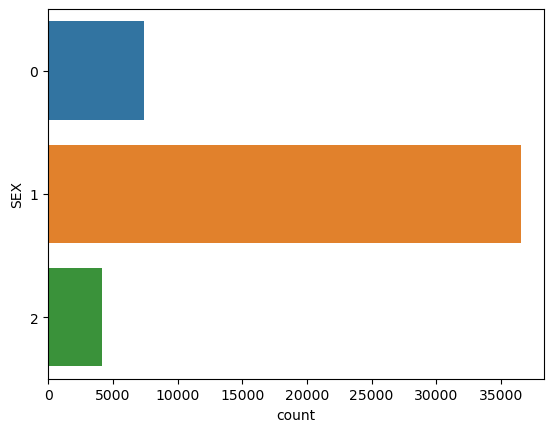

In [32]:
sns.countplot(data=policies, y="SEX")

Text(0, 0.5, 'Frequency')

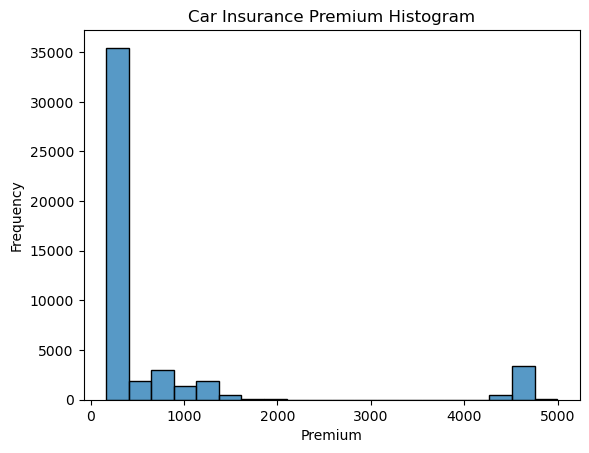

In [33]:
sns.histplot(policies.PREMIUM,bins=20)
plt.title('Car Insurance Premium Histogram')
plt.xlabel('Premium')
plt.ylabel('Frequency')

In [34]:
policies.PREMIUM.describe()

count    48057.000000
mean       772.687905
std       1154.120624
min        167.405000
25%        347.700000
50%        347.700000
75%        462.700000
max       4992.620000
Name: PREMIUM, dtype: float64

<AxesSubplot:xlabel='PREMIUM', ylabel='Count'>

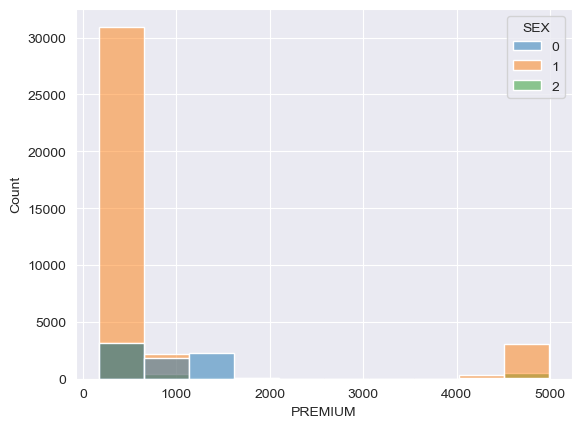

In [103]:
sns.color_palette("flare", as_cmap=True)
sns.histplot(data=policies, x="PREMIUM", bins=10, hue="SEX", palette="tab10")

<AxesSubplot:xlabel='PROD_YEAR', ylabel='Count'>

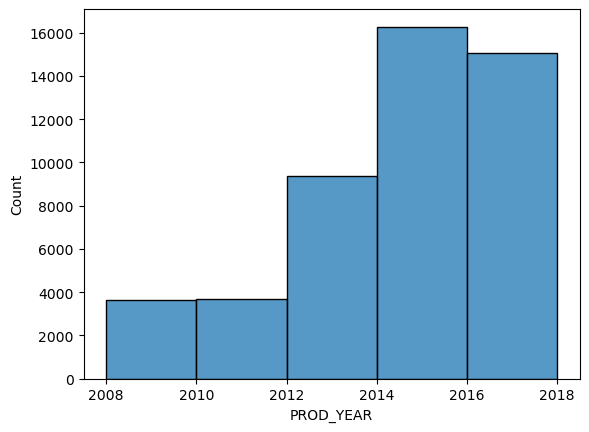

In [35]:
sns.histplot(policies.PROD_YEAR,bins=5)

<AxesSubplot:xlabel='SEATS_NUM', ylabel='Count'>

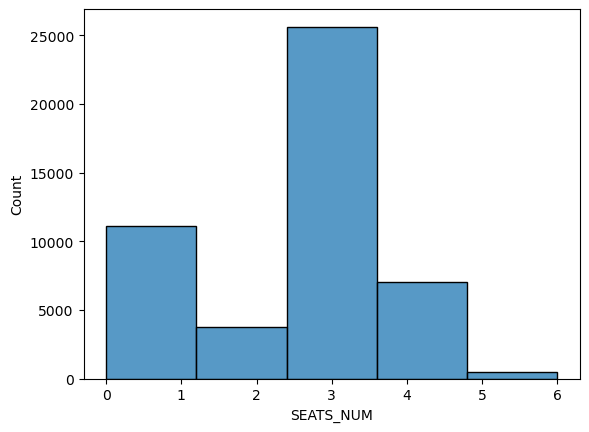

In [36]:
sns.histplot(policies.SEATS_NUM,bins=5)

In [37]:
# policies.SEATS_NUM.describe()

In [38]:
policies.CARRYING_CAPACITY.describe()

count    48057.000000
mean         1.057682
std          2.246291
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: CARRYING_CAPACITY, dtype: float64

<AxesSubplot:xlabel='CCM_TON', ylabel='Count'>

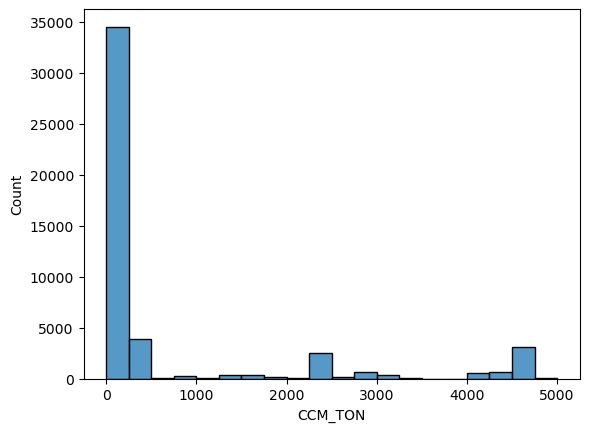

In [39]:
sns.histplot(policies.CCM_TON,bins=20)

In [40]:
policies.CLAIM_PAID.describe()

count    48057.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: CLAIM_PAID, dtype: float64

<AxesSubplot:xlabel='count', ylabel='TYPE_VEHICLE'>

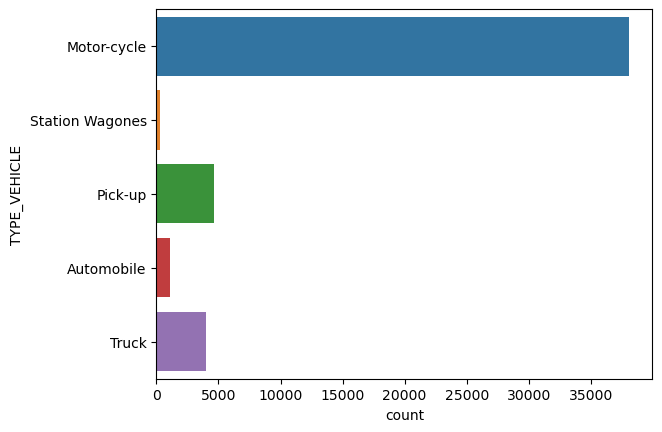

In [41]:
sns.countplot(data=policies, y="TYPE_VEHICLE")

<AxesSubplot:xlabel='count', ylabel='USAGE'>

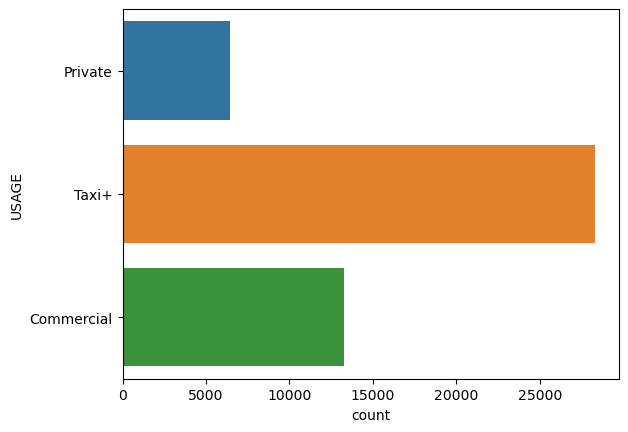

In [42]:
sns.countplot(data=policies, y="USAGE")

## Correlation

In [43]:
policies.drop(['INSURED_VALUE','CLAIM_PAID'], axis=1, inplace=True)

<AxesSubplot:>

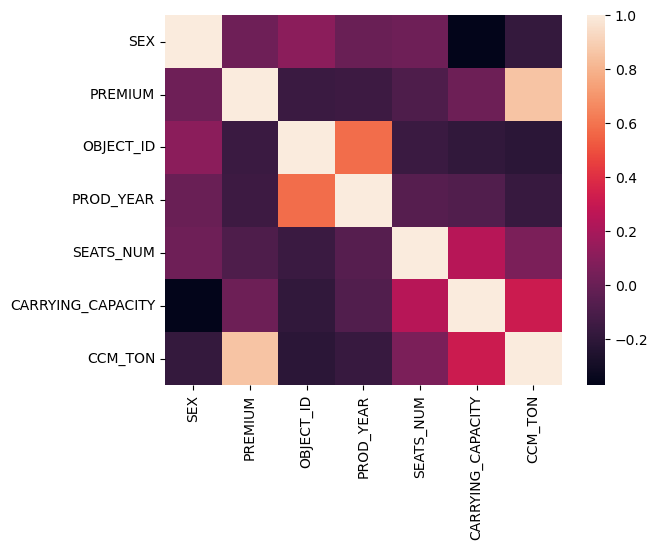

In [44]:
matrix = policies.corr().round(2)
sns.heatmap(matrix)

In [45]:
corr = policies.corrwith(policies.PREMIUM)
print(corr.sort_values())

OBJECT_ID           -0.159750
PROD_YEAR           -0.147945
SEATS_NUM           -0.089869
CARRYING_CAPACITY    0.014368
SEX                  0.015051
CCM_TON              0.862414
PREMIUM              1.000000
dtype: float64


In [46]:
corr = policies_dum.corrwith(policies_dum.PREMIUM)
print(corr.sort_values())

TYPE_VEHICLE_Motor-cycle       -0.714994
USAGE_Taxi+                    -0.401673
MAKE_BAJAJI                    -0.371402
OBJECT_ID                      -0.159750
USAGE_Private                  -0.150090
PROD_YEAR                      -0.147945
MAKE_TVS                       -0.116912
MAKE_BOXER                     -0.108310
SEATS_NUM                      -0.089869
MAKE_YAMAHA                    -0.067171
MAKE_BAJAJ                     -0.052229
MAKE_BMW                       -0.049024
MAKE_LIFAN                     -0.046827
MAKE_ HERO                     -0.045727
MAKE_FORCE                     -0.042195
MAKE_SUZUKI                    -0.033298
MAKE_DISCOVERY                 -0.028838
MAKE_PLATENA                   -0.021657
MAKE_HONDA                     -0.017773
TYPE_VEHICLE_Automobile        -0.013706
MAKE_VITZ                      -0.005396
MAKE_HYUNDAI                   -0.003027
MAKE_KIA                       -0.002938
MAKE_VOLKS WAGON               -0.002291
MAKE_ATOZ       

## Test / Train Dataset

In [47]:
# features
features = policies_dum[['SEX','CARRYING_CAPACITY','CCM_TON','TYPE_VEHICLE_Automobile','TYPE_VEHICLE_Motor-cycle','TYPE_VEHICLE_Pick-up',
                         'TYPE_VEHICLE_Station Wagones','MAKE_BAJAJI','MAKE_NISSAN','MAKE_ISUZU','USAGE_Taxi+','SEATS_NUM']]
# target
target = policies_dum['PREMIUM']

In [48]:
train_X, test_X, train_y, test_y = train_test_split(
    features, target, shuffle=True , test_size=0.3)

## Grid Search

In [49]:
# Standard Scale
scaler = StandardScaler()

In [50]:
scaled_train_X = scaler.fit_transform(train_X) 
scaled_test_X = scaler.transform(test_X)

In [69]:
# Default Linear Regression
reg = LinearRegression()

In [70]:
reg.fit(scaled_train_X,train_y)
reg.score(scaled_test_X,test_y)

0.9814823173364828

In [71]:
y_pred = reg.predict(scaled_test_X)
mse = sqrt(mean_squared_error(y_true=test_y, y_pred=y_pred))
print(mse)

156.4663356586446


In [54]:
#fit linear regression model
model = sm.OLS(train_y, train_X).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                PREMIUM   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          9.490e+04
Date:                Wed, 24 Apr 2024   Prob (F-statistic):                        0.00
Time:                        19:54:31   Log-Likelihood:                     -2.3148e+05
No. Observations:               33639   AIC:                                  4.630e+05
Df Residuals:                   33627   BIC:                                  4.631e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [55]:
from sklearn.linear_model import Ridge
# Default Linear Regression
ridge = Ridge(alpha=1)
ridge.fit(scaled_train_X,train_y)
ridge.score(scaled_test_X,test_y)

0.9814774842015105

In [56]:
y_pred = ridge.predict(scaled_test_X)
mse = sqrt(mean_squared_error(y_true=test_y, y_pred=y_pred))
print(mse)

156.4867532669196


In [57]:
from sklearn.linear_model import Lasso
# Default Linear Regression
lasso = Lasso(alpha=0.5)
lasso.fit(scaled_train_X,train_y)
lasso.score(scaled_test_X,test_y)

0.9813998846788708

In [58]:
y_pred = lasso.predict(scaled_test_X)
mse = sqrt(mean_squared_error(y_true=test_y, y_pred=y_pred))
print(mse)

156.8142089312175


In [72]:
residual = (test_y - y_pred)

In [73]:
residual

483845     23.209688
400355    -22.451173
455094      1.044636
497505     92.548827
484196    -30.135761
             ...    
379809    -22.451173
493174    -22.451173
455170    -32.326159
492851   -254.648807
479566    -10.009954
Name: PREMIUM, Length: 14418, dtype: float64

Text(0, 0.5, 'Insurance Premium ($) Residuals')

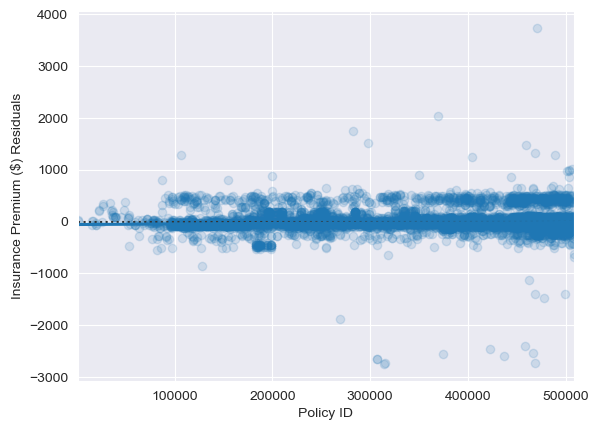

In [85]:
sns.set_style('darkgrid')
sns.residplot(residual.index, residual, lowess=True, scatter_kws={'alpha':0.15})
plt.xlabel('Policy ID')
plt.ylabel('Insurance Premium ($) Residuals')